In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

from tqdm import tqdm

from matplotlib import pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.sequence = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.sequence(x)

class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.linear = nn.Linear(4, 1)

    def forward(self, x):
        return self.linear(x)

In [4]:
GAMMA = 0.99

total_rewards = []
total_estimate_rewards = []

for baseline in ['none', 'estimate']:
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=.002)
    eps = np.finfo(np.float32).eps.item()
    
    v = Linear()
    v_loss = nn.MSELoss()
    v_optimizer = optim.SGD(v.parameters(), lr=0.01)
    
    for i in tqdm(range(1000)):
        state = env.reset()

        rewards = []
        states = [state]
        log_probs = []

        terminal = False

        while not terminal:
            # Action selection
            state = torch.from_numpy(state).float().unsqueeze(0)
            c = Categorical(policy(state))
            action = c.sample()
            log_probs.append(c.log_prob(action))

            # Carry out the action
            state, reward, terminal, _ = env.step(action.item())
            
            if not terminal:
                states.append(state)
                
            rewards.append(reward)

        if baseline == 'estimate':
            total_estimate_rewards.append(sum(rewards))
        else:
            total_rewards.append(sum(rewards))

        # Calculate the returns
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        
        values = v(torch.FloatTensor(states))
        if baseline == 'estimate':
            returns = returns - values.data.squeeze()

        # Calculate the loss
        policy_loss = [-log_prob * R for log_prob, R in zip(log_probs, returns)]

        # Backprop for the NN
        optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()
        
        # Backprop for the value estimator
        v_optimizer.zero_grad()
        estimate_loss = v_loss(values, returns)
        estimate_loss.backward()
        v_optimizer.step()

100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


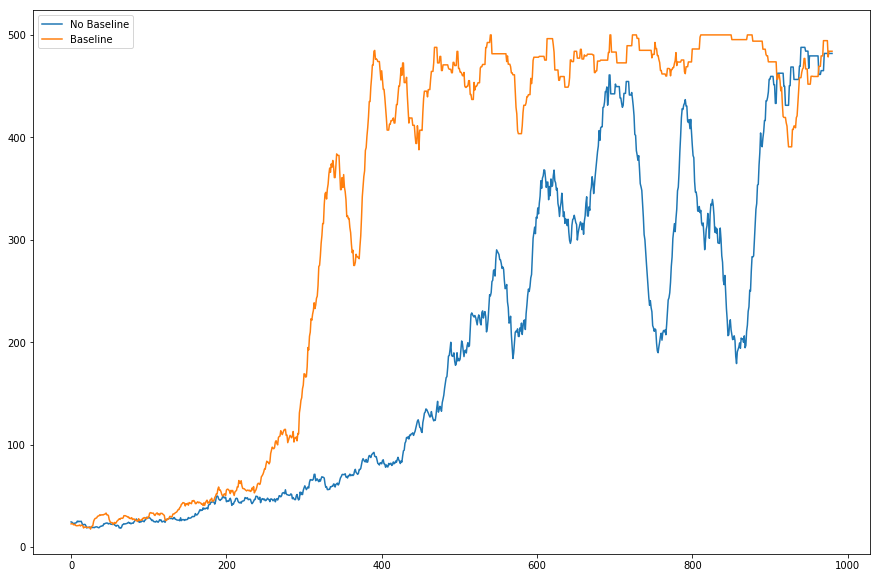

In [5]:
N=20
plt.figure(figsize=(15,10))
plt.plot(np.convolve(total_rewards, np.ones((N,))/N, mode='valid'), label='No Baseline')
plt.plot(np.convolve(total_estimate_rewards, np.ones((N,))/N, mode='valid'), label='Baseline')
plt.legend()
plt.show()